In [1]:
#Importing libraries
import tensorflow as tf
import keras 
from keras.models import model_from_json
from keras import backend
import numpy as np

import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as matp

import scipy.ndimage
from scipy import misc

import os
import random

import math
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Populating the interactive namespace from numpy and matplotlib


#### Hyper parameters used in the original paper:

In [2]:
#Block size
B = 8

#Sensing rate R = M/N
#Sensing matrix is MxN
R = 0.25

#Number of reconstruction layers
#K =2 two hidden layers for reconstruction

#Redundancy factor
T = 8

# 1. Data

### 1.1 Reading the images from the file

In [3]:
#unzipping the file
import zipfile
zip_ref = zipfile.ZipFile('Data.zip', 'r') 
zip_ref.extractall('input_data') 
zip_ref.close()

In [4]:
#Reads all the images from the file and save them in a list as Type=unit8
#3-channels of the images share the same info. So one channel is only used
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        
        imagePath = os.path.join(folder,filename)
        
        if imagePath == folder + '.DS_Store':
            continue
        else:
            img = cv2.imread(imagePath,cv2.IMREAD_UNCHANGED)
            if img is not None:
                images.append(img[:,:,0])
                
    return images

In [5]:
images = load_images_from_folder('input_data/Data')

In [6]:
#test
print(type(images))
print(len(images))
print(images[0].shape)
print(images[0].dtype)
np.max(images[0])

<class 'list'>
100
(768, 1024)
uint8


254

In [7]:
#image shape
img_shape = images[0].shape

### 1.2 Compression and Decompression

In [8]:
#This function gets all the images and split them into blocks of BxB and save each block into a row of an array
def compression(image,B):
    
    R = len(image)
    C = len(image[0])
    
    res = []
    
    for r in range(0,R,B):
        for c in range(0,C,B):
            #segment BxB blocks and faltten them into a vector with len=B^2
            tmp = image[r:B+r,c:c+B].flatten()
            res.append(tmp)
            
    return np.asarray(res)    

#This function gets an array with shape = (len(image)xlen(image[0])/B^2,B^2)
#returns and image with shape len(image)xlen(image[0]) 
def decompression(arr,B,img_shape):
    
    numBlocks_R = int(img_shape[0]/B)
    numBlocks_C = int(img_shape[1]/B)
    
    #makes an empty array
    newImage=np.empty((img_shape[0],img_shape[1]))
    
    for r in range(numBlocks_R):
        for c in range(numBlocks_C):
            
            if arr.size != 0:
                tmp = arr[0].reshape((B,B))
                arr = np.delete(arr,0,0)
                newImage[r*B:(r+1)*B , c*B:(c+1)*B] = tmp
                
    return newImage

### 1.3 Function: Compress all the images and save them into a numpy array

In [9]:
def building_Input(images,B):
    input_X = []
    
    for i in images:
        input_X.extend(compression(i,B))
        
    return np.asarray(input_X)

In [10]:
#Test
test = building_Input(images,B)

In [11]:
#Each image construct 3072 images = 768/16 * 1024/16
print(len(test))
print(type(test))
print(len(test[0]))#should be B*B

1228800
<class 'numpy.ndarray'>
64


### 1.4 Splitting Data 

In [12]:
#Split your data to test and train
X_train_Or, X_test_Or, y_train_Or, y_test_Or = train_test_split(images,images, test_size=0.30, random_state=42)

In [13]:
print("Number of images in Training set: ",len(X_train_Or))
print("Number of images in Test set: ",len(X_test_Or))

Number of images in Training set:  70
Number of images in Test set:  30


In [14]:
def save_images_to_folder(folder,img_name,images):
    path = folder+"/"+ img_name
    for i,im in enumerate(images):
        cv2.imwrite(path+str(i)+'.JPEG',im)  
    return 

In [15]:
#Saving images in to a file
save_images_to_folder('train','train_',X_train_Or)
save_images_to_folder('test','test_',X_test_Or)

### 1.5 Making data ready for training

In [15]:
#Train
X_train = building_Input(X_train_Or,B)
y_train = X_train

#Test
X_test = building_Input(X_test_Or,B)
y_test = X_test

In [16]:
print("Number of blocks in Training set: ",len(X_train))
print("Number of blocks in Test set: ",len(X_test))

Number of blocks in Training set:  860160
Number of blocks in Test set:  368640


In [17]:
#cheking the dimensions

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(860160, 64)
(860160, 64)
(368640, 64)
(368640, 64)


In [18]:
X_train

array([[ 68,  68,  68, ..., 163, 163, 163],
       [ 68,  68,  68, ..., 158, 158, 158],
       [ 68,  68,  68, ...,  88,  74,  74],
       ...,
       [177, 177, 177, ...,  68,  68,  68],
       [174, 174, 174, ...,  68,  68,  68],
       [178, 178, 178, ...,  68,  68,  68]], dtype=uint8)

# 2. Building the Model

### 2.1 Adding Layers

In [19]:
def build_Model(B,R,T):
    ##Set random seeds
    np.random.seed(23)
    tf.set_random_seed(23)
    
    #Create a model
    model = keras.models.Sequential()
    
    #Add layers
    #First hidden layer
    model.add(
         keras.layers.Dense(
                            units = int(B*B*R),
                            input_dim = B*B,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #First Reconstruction Layer
    model.add(
         keras.layers.Dense(
                            units = B*B*T,
                            input_dim = B*B*R,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #Second Reconstruction Layer
    model.add(
         keras.layers.Dense(
                            units = B*B*T,
                            input_dim = B*B*T,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #Output Layer
    #If you don't specify any activation, no activation is applied. "linear" activation: a(x) = x).
    model.add(
         keras.layers.Dense(
                            units = B*B,
                            input_dim = B*B*T,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros'))
    return model

In [20]:
model = build_Model(B,R,T)

In [21]:
#A custome metric function
#https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio

def PSNR(y_true, y_pred):
    
    max_I = 255.0 
    
    loge = 10.0 * backend.log((max_I ** 2) / (backend.mean(backend.square(y_pred - y_true)))) 
    log10 = loge/backend.log(10.0)#backend.log is not base 10
    
    return log10

### 2.2 Optimizer and Cost Function

In [22]:
#Choose optimizer and a cost function

RMSprop_optimizer = keras.optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=1e-7)

model.compile(optimizer = RMSprop_optimizer , loss = 'mean_squared_error', metrics=[PSNR])

In [23]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               8704      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
Total params: 305,232
Trainable params: 305,232
Non-trainable params: 0
_________________________________________________________________
None


### 2.3 Callbacks

In [24]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.PSNR = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.PSNR.append(logs.get('PSNR'))

In [25]:
loss_history = LossHistory()

### 2.3 Training the model

In [26]:
#Training
history = model.fit(X_train, y_train,
                    batch_size=64, epochs =50,
                    verbose = 1,
                    validation_data=(X_test, y_test),
                    callbacks=[loss_history])

Train on 860160 samples, validate on 368640 samples
Epoch 1/50
860160/860160 [==============================] - 64s 75us/step - loss: 267.9846 - PSNR: 31.4900 - val_loss: 30.9289 - val_PSNR: 36.2500
Epoch 2/50
860160/860160 [==============================] - 54s 63us/step - loss: 26.9736 - PSNR: 35.3309 - val_loss: 23.6556 - val_PSNR: 37.7684
Epoch 3/50
860160/860160 [==============================] - 54s 63us/step - loss: 22.0507 - PSNR: 36.2888 - val_loss: 20.0323 - val_PSNR: 38.8355
Epoch 4/50
860160/860160 [==============================] - 54s 62us/step - loss: 19.3203 - PSNR: 36.8738 - val_loss: 18.2705 - val_PSNR: 38.9681
Epoch 5/50
860160/860160 [==============================] - 54s 63us/step - loss: 17.6681 - PSNR: 37.3277 - val_loss: 16.8467 - val_PSNR: 39.4477
Epoch 6/50
860160/860160 [==============================] - 53s 62us/step - loss: 16.4835 - PSNR: 37.6290 - val_loss: 15.6254 - val_PSNR: 40.1820
Epoch 7/50
860160/860160 [==============================] - 53s 62us/st

#### 2.3.1 Saving the Model and the History

In [27]:
#Saving the model

model_json = model.to_json()

with open("model3_B8_4.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model3_B8_4.h5")
print("Saved model to disk")

Saved model to disk


In [28]:
#save the history of training
import pickle
pickle_out = open("history3_B8_4.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

#### 2.3.2 Uploading the Model and the History 

In [ ]:
#load your model

json_file = open('model3_B8.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)

model.load_weights("model3_B8.h5")


In [ ]:
#if you load your model and weight you need to compile it again
model.compile(optimizer = adam_optimizer , loss = 'mean_squared_error', metrics=[PSNR])

# 3.Predicting

In [29]:
y_train_pred = model.predict(X_train,verbose = 1)
y_test_pred = model.predict(X_test,verbose = 1)

368640/368640 [==============================] - 9s 25us/step


In [30]:
y_train_pred

array([[ 52.766544,  73.138435,  68.2305  , ..., 162.5788  , 163.0621  ,
        162.4753  ],
       [ 62.964317,  59.934967,  73.21729 , ..., 148.82607 , 155.78584 ,
        163.26828 ],
       [ 69.31316 ,  63.87203 ,  70.3191  , ...,  86.00225 ,  63.658466,
         81.4102  ],
       ...,
       [175.82668 , 175.94214 , 176.42845 , ...,  68.34441 ,  67.36859 ,
         67.38084 ],
       [172.11392 , 172.6265  , 173.69403 , ...,  66.317955,  66.05919 ,
         68.66221 ],
       [178.41922 , 177.19487 , 181.11649 , ...,  66.75647 ,  68.41084 ,
         63.609203]], dtype=float32)

In [31]:
y_test_pred

array([[ 52.766544,  73.138435,  68.2305  , ..., 162.5788  , 163.0621  ,
        162.4753  ],
       [ 73.195404,  64.91249 ,  62.597706, ..., 157.74524 , 192.21234 ,
        188.23416 ],
       [ 61.994167,  64.51957 ,  66.93811 , ...,  82.70611 ,  53.63382 ,
         77.975746],
       ...,
       [177.58641 , 177.21384 , 177.40529 , ...,  65.303085,  64.475784,
         64.340416],
       [173.74971 , 174.18341 , 175.09683 , ...,  65.210915,  65.18635 ,
         66.603935],
       [174.43716 , 173.74315 , 178.17357 , ...,  62.36797 ,  66.38448 ,
         61.67206 ]], dtype=float32)

# 4. Evaluation

In [32]:
#Evaluate on the whole image
imgL = int(img_shape[0]*img_shape[1]/(B*B))


scores_Train = model.evaluate(X_train, y_train, verbose=1,batch_size=imgL)

print("Training PSNR:")
print("%s: %.2f%%" % (model.metrics_names[1], scores_Train[1]))

860160/860160 [==============================] - 1s 1us/step
Training PSNR:
PSNR: 39.32%


In [33]:
scores_Test = model.evaluate(X_test, y_test, verbose=1,batch_size=imgL)

print("Test PSNR:")
print("%s: %.2f%%" % (model.metrics_names[1], scores_Test[1]))

368640/368640 [==============================] - 0s 1us/step
Test PSNR:
PSNR: 39.34%


### 4.1 Plots

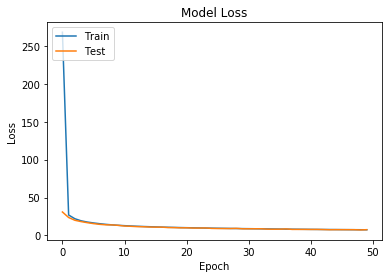

In [34]:
#plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

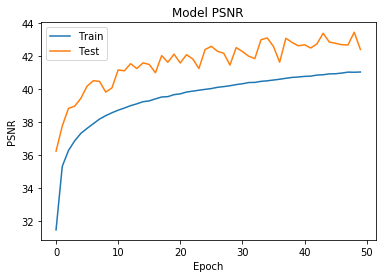

In [35]:
#plotting PSNR
plt.plot(history.history['PSNR'])
plt.plot(history.history['val_PSNR'])
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 5. Reconstrcut the predicted images

### 5.1 Function: reconstrcution

In [36]:
#number of rows for each image = (len(image)xlen(image[0])/B^2
#gets an array and reconstruct the images
def building_output(result,img_shape):
    
    imgL = int(img_shape[0]*img_shape[1]/(B*B))
    out_put = []
    
    for i in range(0,len(result),imgL):
        out_put.append(decompression(result[i:i+imgL],B,img_shape))
    
    return out_put

### 5.2 Reconstrcuting train and test

In [37]:
#reconstructing training predictions
dec_img_train = building_output(y_train_pred,img_shape)

#reconstructing test predictions
dec_img_test = building_output(y_test_pred,img_shape)

In [38]:
#test
print(len(dec_img_train))
print(len(dec_img_test))

70
30


### 5.3 Plotting images

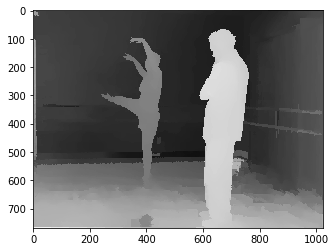

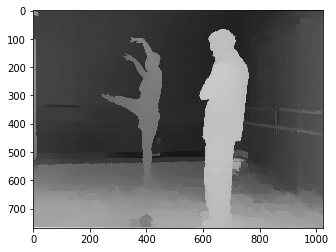

39.42930815270186


In [40]:
#train
img_in=X_train_Or[50]
img_out = dec_img_train[50]
imgplot = plt.imshow(img_in,cmap='gray')
plt.show()
imgplot = plt.imshow(img_out,cmap='gray')
plt.show()
print(PSNR_Final(img_in,img_out))#PSNR_Final is in section 5.4

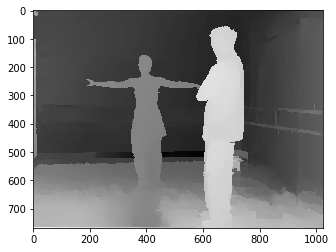

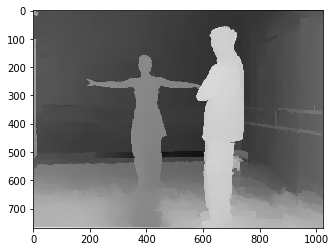

39.71024346135497


In [41]:
#test
img_in_t=X_test_Or[15]
img_out_t = dec_img_test[15]
imgplot = plt.imshow(img_in_t,cmap='gray')
plt.show()
imgplot = plt.imshow(img_out_t,cmap='gray')
plt.show()
print(PSNR_Final(img_in_t,img_out_t))

### 5.3 Saving images

In [42]:
def save_images_to_folder(folder,img_name,images):
    path = folder+"/"+ img_name
    for i,im in enumerate(images):
        cv2.imwrite(path+str(i)+'.png',im)  
    return 

In [43]:
#saving the precited images
save_images_to_folder('train_pred','train_p_B8_4_',dec_img_train)
save_images_to_folder('test_pred','test_p_B8_4_',dec_img_test)

### 5.4 Find the average PSNR 

In [39]:
#Calculate PSNR on the whole image
def PSNR_Final(y_true, y_pred):
    max_I = 255.0 
    tmp =  np.mean(np.square(y_pred - y_true))
    log_res = 10 * np.log10((max_I ** 2) /tmp)
    
    return log_res

In [44]:
#calcualte the average PSNR on a data set
def cal_PSNR_Dataset(output_images,input_images):
    res_psnr = []
    for i,o in enumerate(output_images):
        res_psnr.append(PSNR_Final(input_images[i],o))
    return res_psnr

In [45]:
res_psnr_train = cal_PSNR_Dataset(dec_img_train,X_train_Or)
print("average PSNR on training: ",np.mean(res_psnr_train))

average PSNR on training:  39.31628521652831


In [46]:
res_psnr_train

[38.98138223248108,
 39.097745260112575,
 39.409801708706134,
 39.47416055115208,
 39.626877846099255,
 40.13202483118964,
 38.78050560451517,
 38.61772247589204,
 39.534483494598014,
 38.96433069283324,
 38.833606694820595,
 39.67790451891829,
 39.570335145648016,
 39.88289097414763,
 39.664028466858355,
 39.042189420653905,
 38.89886518656388,
 39.074874507740006,
 39.488705321498074,
 38.59802149674234,
 39.60230328850165,
 39.699730022608236,
 40.10221356987586,
 39.46073866031591,
 39.31856446145381,
 38.62728774909064,
 38.777546276259564,
 39.232125206815425,
 39.585664635667285,
 39.66274030208555,
 39.049235170619156,
 39.41762762798325,
 39.258518759287064,
 39.45398922237484,
 39.70976930156691,
 39.627964175710105,
 39.43098650231076,
 39.09978436845079,
 39.63904194392291,
 39.482923990418705,
 38.9266000611751,
 38.957031846073804,
 38.785245044064936,
 39.83934733852784,
 39.33166461440018,
 38.74114729455677,
 38.80268460431353,
 38.98073764600129,
 39.03892032414288,
 

In [47]:
res_psnr_test = cal_PSNR_Dataset(dec_img_test,X_test_Or)
print("average PSNR on the test set: ",np.mean(res_psnr_test))

average PSNR on the test set:  39.33530254192251


In [50]:
res_psnr_test

[39.31867619944832,
 39.505898646000844,
 39.887652444084466,
 39.51045032454966,
 39.3581009258388,
 39.31100256270535,
 38.74961583451197,
 39.7208584906067,
 39.40921048893061,
 39.42604934627098,
 39.35500146082976,
 39.7176328106203,
 38.614255618466856,
 39.33679211035024,
 39.76431689480995,
 39.71024346135497,
 39.37457163525199,
 39.10888632361243,
 39.46540937749109,
 39.522382652237575,
 39.61313183971453,
 38.93951199680126,
 39.388167514265675,
 39.11208401554841,
 39.41632948492417,
 39.03842594269872,
 39.5613583628632,
 38.56975049606245,
 39.03941638443305,
 39.213892612390936]